<div style="display: flex; flex-direction: column; align-items: center; max-width: 100%; padding: 20px 0; margin: auto;">
    <img src="https://media.licdn.com/dms/image/v2/D4D3DAQFGx0XnuUvugA/image-scale_191_1128/image-scale_191_1128/0/1662458005755/nova_ims_information_management_school_cover?e=2147483647&v=beta&t=J3Q4LlZi36_4UAFhj2019QdtfXLn0kQwaX25jgaBhOQ" 
         alt="Logo" 
         style="width: 100%; max-width: 800px; height: auto; max-height: 150px; object-fit: cover; border: 3px solid hsla(120, 71.40%, 43.90%, 0.30); border-radius: 5px;">
    <div style="text-align: center; padding: 10px 0; max-width: 800px;">
        <h5 style="margin: 10px 0;">This analysis is conducted as part of the <b><i>Neural and Evolutionary Learning</i></b> course, a component of the Master's program in Data Science and Advanced Analytics at the <b><u>Nova Information Management School</u></b>.</h5>
    </div>
    <h1 style="color: hsla(120, 71.40%, 43.90%, 0.30); margin: 10px 0;"><b>Predict the Crude Protein Weight</b></h1>
</div>

<div style="text-align: center; margin: 20px 0;">
    <h3 style="margin-bottom: 15px;"><u>Group 22</u></h3>
    <table style="margin: 0 auto; border-collapse: collapse; width: 80%; max-width: 500px;">
        <thead>
            <tr>
                <th style="border-bottom: 1px solid #ddd; padding: 8px;">Student Name</th>
                <th style="border-bottom: 1px solid #ddd; padding: 8px;">Student ID</th>
            </tr>
        </thead>
        <tbody>
            <tr>
                <td style="border-bottom: 1px solid #ddd; padding: 8px;">Catarina Nunes</td>
                <td style="border-bottom: 1px solid #ddd; padding: 8px;">20230083</td>
            </tr>
            <tr>
                <td style="border-bottom: 1px solid #ddd; padding: 8px;"></td>
                <td style="border-bottom: 1px solid #ddd; padding: 8px;"></td>
            </tr>
            <tr>
                <td style="padding: 8px;"></td>
                <td style="padding: 8px;"></td>
            </tr>
        </tbody>
    </table>
</div>

<a id="idx"></a>
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: center; margin-top: 20px; margin-bottom: 20px;">
    <h1 style="color: white; margin: 0;">Index</h1>
</div>

1. [Preprocessing the data](#preprocessing)
2. [Choosing the method and parameters](#method-selection)
3. [Estimating the predictive error](#error-estimation)
4. [Inducing the final model](#model-induction)
5. [Testing the final model](#final-testing)

#### Metadata

|Feature |Definition|
|----|-----|
|wing_tag |Chicken unique ID|
|weight |The chicken total weight|
|hot_carcass_weight |The weight of the carcass immediately after slaughter|
|carcass_weight_with_head_and_legs |The weight of the carcass including the head and legs|
|cold_carcass_weight| The weight of the carcass after cooling|
|breast_weight |The weight of the breast meat of the chicken|
|thigh_weight |The weight of the thigh meat of the chicken|
|spleen |The weight of the chicken’s spleen|
|liver |The weight of the chicken’s liver|
|heart |The weight of the chicken’s heart|
|intestine |The weight of the chicken’s intestine|
|empty_muscular_stomach| Indicates the presence or absence of the empty muscular stomach of the chicken|
|glandular_stomach |The weight of the chicken’s glandular stomach|
|crude_protein| The weight of crude protein in the carcass|
|ether_extract |The weight of ether extract, which measures the total fat in the carcass|

#### Imports & Settings

In [60]:
#pip install gsgp_slim

In [66]:
# pip install slim_gsgp

In [62]:
#pip install -r requirements.txt

In [148]:
# Imports
import numpy as np
import pandas as pd

import os
import pickle
import datetime
import torch
import random

#import scikit_posthocs as sp
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.datasets import fetch_openml
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import wilcoxon, friedmanchisquare
#import scikit_posthocs as sp

import warnings
warnings.filterwarnings('ignore')

In [65]:
from slim.main_gp import gp  # import the slim library
from slim.datasets.data_loader import load_ppb  # import the loader for the dataset PPB
from slim.evaluators.fitness_functions import rmse  # import the rmse fitness metric
from slim.utils.utils import train_test_split  # import the train-test split function

In [14]:
seed = 1111
np.random.seed(seed)
random.seed(seed)

In [15]:
train_color = 'blue'
test_color = 'orange'

In [24]:
#! ls

#### Helpfull Functions

In [35]:
def plot_boxplots(df_clients, columns):
    """
    Plot multiple boxplots horizontally with scrolling enabled.
    """
    n_cols = len(columns)
    
    fig = make_subplots(
        rows=1,
        cols=n_cols,
        shared_yaxes=False,
        horizontal_spacing=0.05,  # space between boxplots
        subplot_titles=[col.replace("_", " ").title() for col in columns]
    )

    for idx, column in enumerate(columns, start=1):
        fig.add_trace(
            go.Box(
                y=df_clients[column],
                name=column.replace("_", " ").title(),
                boxpoints='outliers',  # only show outliers
                whiskerwidth=0.2,
                marker_color='mediumseagreen',
                line_color='seagreen',
                fillcolor='rgba(60,179,113,0.3)',
                marker_size=4
            ),
            row=1,
            col=idx
        )

    fig.update_layout(
        title='Outliers Analysis',
        title_font_size=24,
        plot_bgcolor='white',
        height=600,
        width=300 * n_cols,  # make width proportional to number of boxplots
        showlegend=False
    )

    fig.update_yaxes(zeroline=False)

    fig.show()

### <a id="preprocessing"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: center; margin-top: 20px; margin-bottom: 20px;">
    <h3 style="color: white; margin: 0;">Preprocessing the data</h3>
</div>

[Back to Index](#idx)

#### Data Loading

In [127]:
df = pd.read_excel(r"data\sustavianfeed.xlsx")

c:\Users\catar\anaconda3\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

c:\Users\catar\anaconda3\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



In [128]:
df.head()

,WING TAG,WEIGHT,HOT CARCASS WEIGHT,CARCASS WEIGHT WITH HEAD AND LEGS,COLD CARCASS WEIGHT,BREAST WEIGHT (2),THIGH WEIGHT (2),SPLEEN,LIVER,HEART,INTESTINE,EMPTY MUSCULAR STOMACH,GLANDULAR STOMACH,CRUDE PROTEIN,ETHER EXTRACT
0,G403,2223.3,1429.6,1725.6,1394.0,214.0,489.4,3.716,38.636,9.305,123.171,/,13.170,86.105469,0.38
1,G439,2201.9,1450.2,1769.8,1405.4,236.0,538.7,3.494,34.725,10.084,71.800,45.273,9.781,86.143472,1.66
2,G454,2159.9,1398.4,1724.9,1461.7,241.8,512.1,4.023,31.932,10.635,61.380,/,6.217,86.416898,0.98
3,G465,2198.7,1473.9,1800.4,1425.1,227.7,549.9,3.087,32.326,11.927,64.879,35.861,8.358,85.959935,1.10
4,G428,2003.2,1291.2,1581.6,1260.1,224.7,473.2,3.723,30.105,9.855,68.562,36.526,7.572,81.693637,6.34


lets rename the columns according to the metadata:

In [129]:
# column name mapping
column_mapping = {
    'WING TAG': 'wing_tag',
    'WEIGHT': 'weight',
    'HOT CARCASS WEIGHT': 'hot_carcass_weight',
    'CARCASS WEIGHT WITH HEAD AND LEGS': 'carcass_weight_with_head_and_legs',
    'COLD CARCASS WEIGHT': 'cold_carcass_weight',
    'BREAST WEIGHT (2)': 'breast_weight',
    'THIGH WEIGHT (2)': 'thigh_weight',
    'SPLEEN': 'spleen',
    'LIVER': 'liver',
    'HEART': 'heart',
    'INTESTINE': 'intestine',
    'EMPTY MUSCULAR STOMACH': 'empty_muscular_stomach',
    'GLANDULAR STOMACH': 'glandular_stomach',
    'CRUDE PROTEIN': 'crude_protein',
    'ETHER EXTRACT': 'ether_extract'
}

df = df.rename(columns=column_mapping)

#### Descriptive Summary

In [130]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
weight,96.0,2339.682292,200.943424,1968.400000,2201.775000,2299.500000,2473.800000,2890.500000
hot_carcass_weight,96.0,1521.955208,144.126939,1284.900000,1425.775000,1493.050000,1608.400000,1929.400000
carcass_weight_with_head_and_legs,96.0,1833.378125,154.000550,1554.400000,1723.800000,1809.400000,1922.725000,2262.800000
cold_carcass_weight,96.0,1481.479167,142.830115,1252.600000,1380.825000,1452.800000,1573.700000,1891.700000
breast_weight,96.0,234.116667,37.818405,177.100000,218.775000,231.550000,243.275000,533.200000
thigh_weight,96.0,542.205208,60.994468,177.800000,508.225000,538.100000,573.850000,690.600000
spleen,96.0,4.219917,0.998836,2.464000,3.534250,4.048000,4.817000,7.758000
liver,96.0,36.781427,5.438894,25.916000,33.053000,35.936000,40.485000,53.133000
heart,96.0,12.059240,1.932239,8.561000,10.584250,11.679000,13.449750,17.194000
intestine,96.0,69.149156,11.727467,44.133000,62.274250,68.019500,75.103000,123.171000


In [131]:
df.describe(include='O').T

,count,unique,top,freq
wing_tag,96,96,G403,1
empty_muscular_stomach,96,91,/,5


In [132]:
df.isna().sum()

wing_tag                             0
weight                               0
hot_carcass_weight                   0
carcass_weight_with_head_and_legs    0
cold_carcass_weight                  0
breast_weight                        0
thigh_weight                         0
spleen                               0
liver                                0
heart                                0
intestine                            0
empty_muscular_stomach               0
glandular_stomach                    0
crude_protein                        0
ether_extract                        0
dtype: int64

- no missing values
- `wing_tag` uniquely represents each chicken so can be placed as index.

In [133]:
df.set_index('wing_tag', inplace = True)

In [134]:
df.duplicated().sum()

0

#### Data Types

In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96 entries, G403 to V428
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   weight                             96 non-null     float64
 1   hot_carcass_weight                 96 non-null     float64
 2   carcass_weight_with_head_and_legs  96 non-null     float64
 3   cold_carcass_weight                96 non-null     float64
 4   breast_weight                      96 non-null     float64
 5   thigh_weight                       96 non-null     float64
 6   spleen                             96 non-null     float64
 7   liver                              96 non-null     float64
 8   heart                              96 non-null     float64
 9   intestine                          96 non-null     float64
 10  empty_muscular_stomach             96 non-null     object 
 11  glandular_stomach                  96 non-null     float64
 

In [136]:
df['empty_muscular_stomach'].unique()

array(['/', 45.273, 35.861, 36.526, 40.993, 40.949, 45.323, 42.091,
       49.148, 46.807, 31.103, 49.057, 39.621, 43.128, 53.485, 38.836,
       44.487, 47.665, 50.006, 43.695, 59.547, 61.306, 61.702, 60.063,
       45.428, 53.456, 43.586, 49.648, 63.571, 47.523, 63.86, 64.538,
       42.852, 50.119, 32.665, 35.164, 46.656, 44.855, 44.962, 51.851,
       45.507, 50.136, 43.821, 66.616, 29.712, 40.936, 52.518, 35.408,
       51.944, 41.483, 56.23, 55.663, 42.66, 32.12, 43.964, 75.767,
       45.327, 42.129, 47.964, 44.811, 32.599, 32.947, 38.155, 48.009,
       56.347, 59.583, 51.322, 58.708, 41.917, 40.425, 51.903, 56.698,
       40.7, 45.321, 55.671, 68.602, 44.006, 54.71, 45.636, 34.692,
       48.933, 45.045, 48.02, 42.632, 45.366, 52.457, 49.281, 54.021,
       42.173, 49.7, 46.816], dtype=object)

The metadata for the column `empty_muscular_stomach` specifies that it should be a binary flag, '_Indicates the presence or absence of the empty muscular stomach of the chicken_'. However, the data contains a '/' that represents 'yes' for an empty stomach, and other values that indicate that the stomach is not empty, such as percentages or grams. We will evaluate whether it is more valuable to maintain this column as a float or a binary flag, based on its correlation with the target variable. Ultimately, we plan to adhere to the guidance provided in the metadata, but lets see:

In [137]:
df['empty_muscular_stomach_bin'] = np.where(
    df['empty_muscular_stomach'] == '/', 1, 0
).astype(int)

In [138]:
df['empty_muscular_stomach_float'] = df['empty_muscular_stomach'].replace('/', 0).astype(float)

#### Outliers

In [139]:
plot_boxplots(df, df.columns)

Given the presence of outliers and the small size of the dataset, the best approach is to incorporate the Robust Scaler into the model's pipeline.

#### Correlations

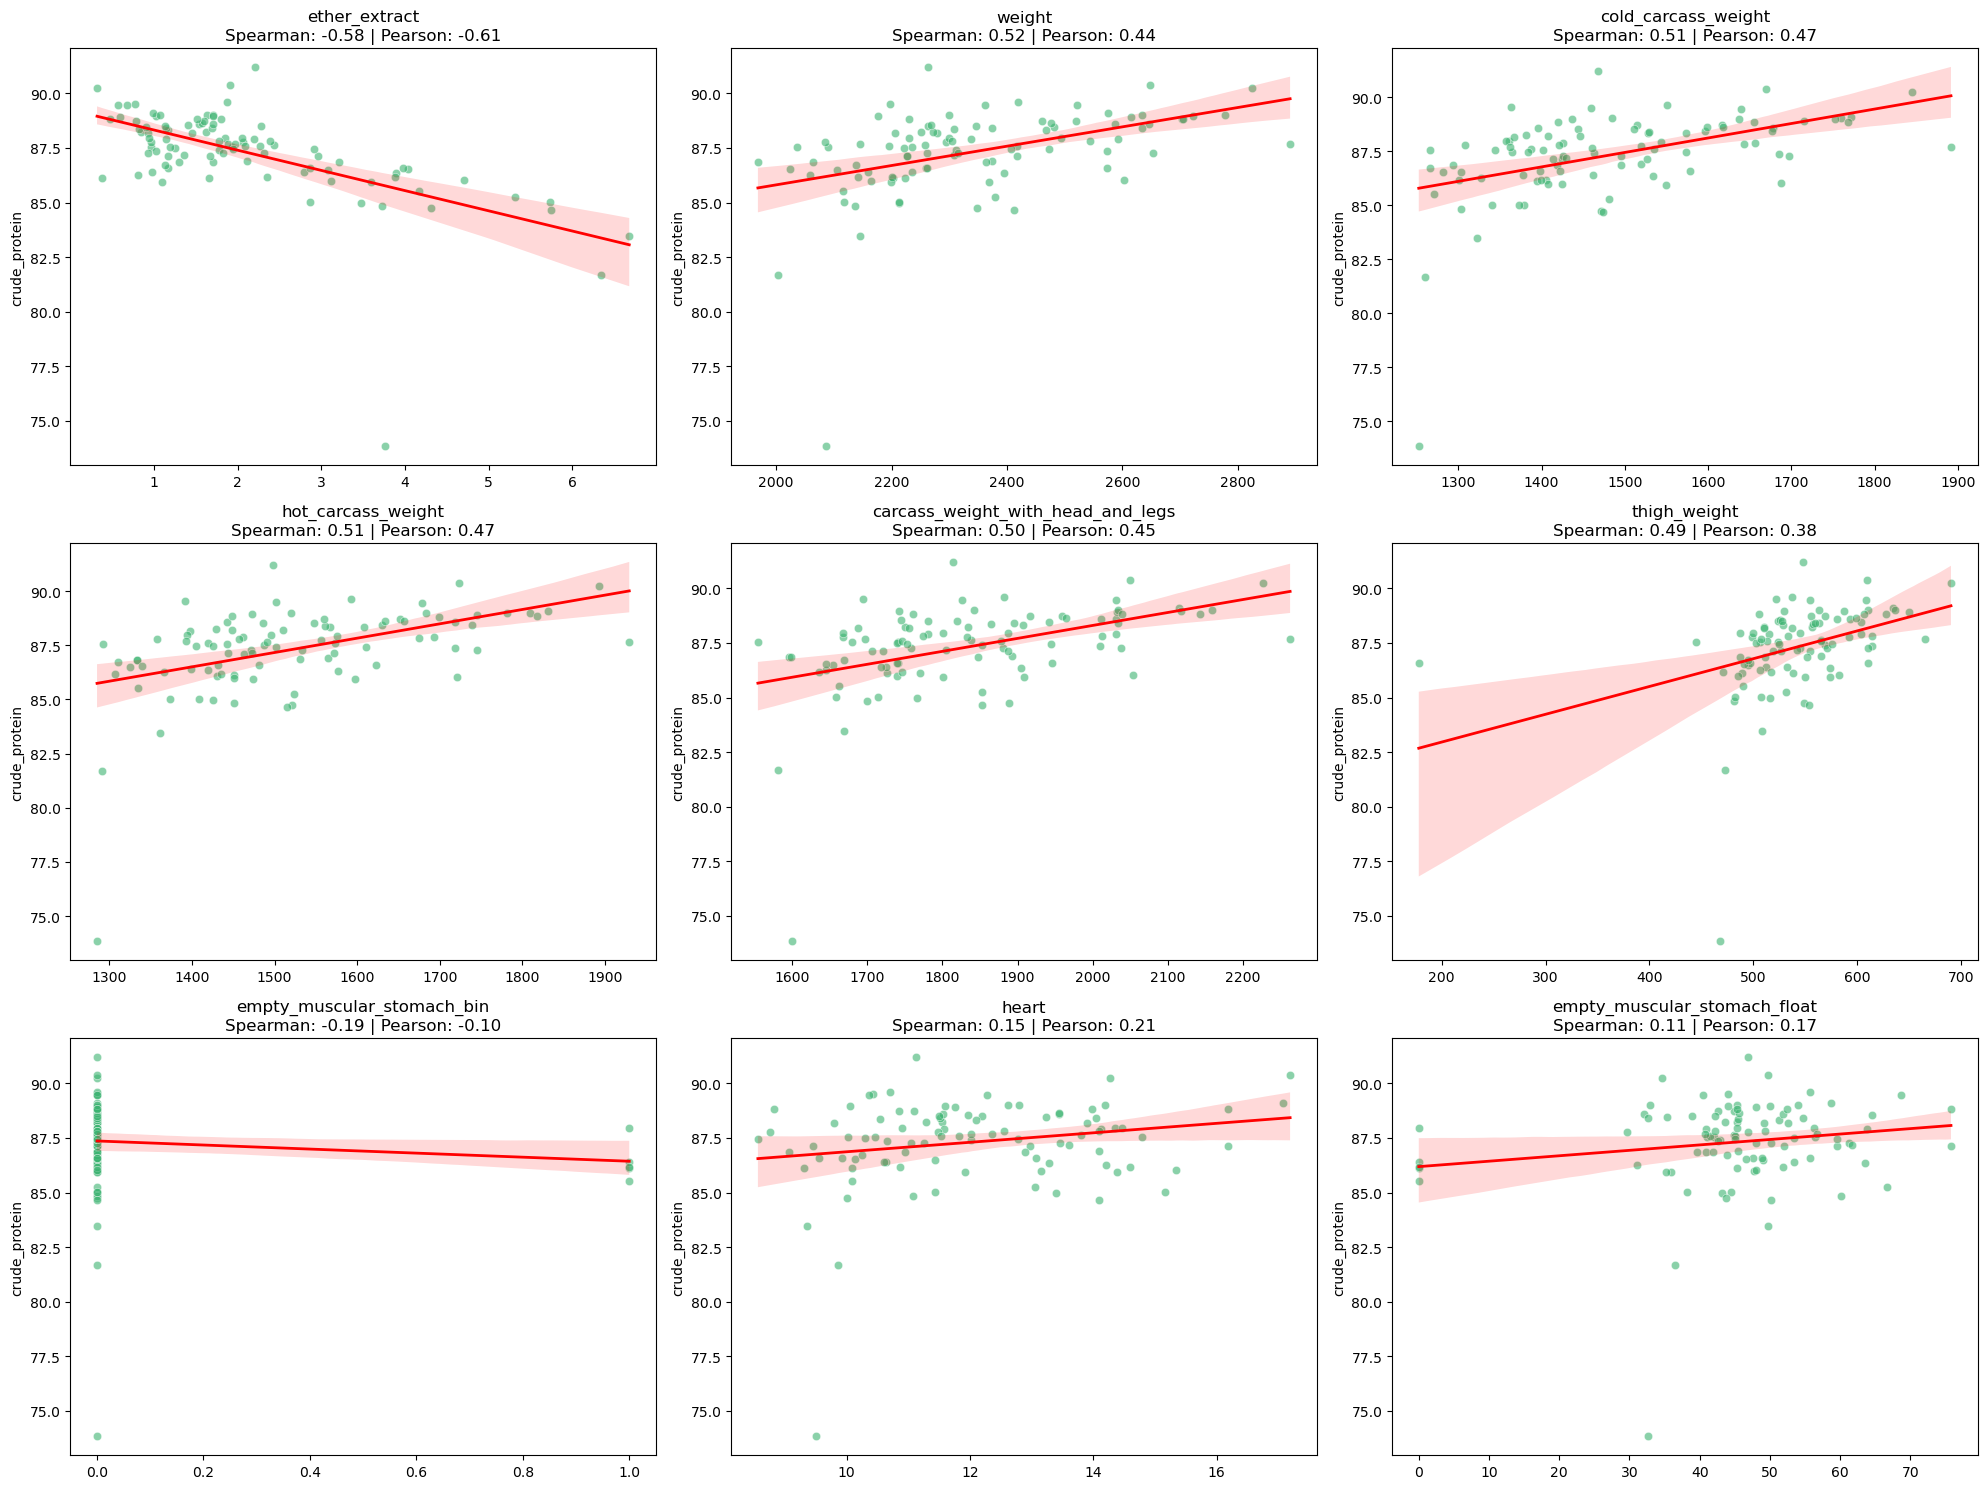

Correlations with crude_protein:


,spearman,pearson
feature,,
ether_extract,-0.582762,-0.612023
weight,0.519340,0.435335
cold_carcass_weight,0.509838,0.467681
hot_carcass_weight,0.508193,0.466773
carcass_weight_with_head_and_legs,0.498589,0.446827
thigh_weight,0.485786,0.379469
empty_muscular_stomach_bin,-0.190323,-0.101427
heart,0.153040,0.205162
liver,0.145050,0.123440


In [140]:
#code adapted from previous work

# correlations with crude_protein
target = 'crude_protein'
numeric_cols = df.select_dtypes(include=['number']).columns
features = [col for col in numeric_cols if col != target] 

# both correlation types
corr_data = df[features + [target]]  # Note: target needs to be in a list
spearman_corr = corr_data.corr(method='spearman')[target]
pearson_corr = corr_data.corr(method='pearson')[target]

# Combine into a DataFrame for easier analysis
corr_df = pd.DataFrame({
    'feature': features,
    'spearman': spearman_corr[features],
    'pearson': pearson_corr[features]
}).sort_values(by='spearman', key=abs, ascending=False)

# Set threshold (adjust as needed)
threshold = 0.15
significant_features = corr_df[(abs(corr_df['spearman']) >= threshold) | 
                             (abs(corr_df['pearson']) >= threshold)]

# Plot settings
num_features = len(significant_features)
num_cols = 3
num_rows = (num_features + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5*num_rows))
if num_features > 0:  # Only proceed if there are significant features
    if num_rows == 1:
        axes = axes.reshape(1, -1)  # Ensure axes is always 2D

    # Plot each significant feature against target
    for i, (_, row) in enumerate(significant_features.iterrows()):
        ax = axes[i//num_cols, i%num_cols]
        feature = row['feature']
        
        # Scatterplot
        sns.scatterplot(x=df[feature], y=df[target], ax=ax, color='mediumseagreen', alpha=0.6)
        
        # Regression line if possible
        if df[feature].nunique() > 1:
            try:
                sns.regplot(x=df[feature], y=df[target], ax=ax, 
                            scatter=False, color='red', line_kws={'linewidth':2})
            except:
                pass
        
        # Add correlation info to title
        ax.set_title(f"{feature}\nSpearman: {row['spearman']:.2f} | Pearson: {row['pearson']:.2f}")
        ax.set_xlabel('')
        ax.set_ylabel('crude_protein')

    # Hide empty subplots
    for j in range(i+1, num_rows*num_cols):
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout()
    plt.show()

    # Show correlation table
    corr_df = corr_df.set_index('feature')
    print("Correlations with crude_protein:")
    display(corr_df.style.background_gradient(cmap='BuGn', vmin=-1, vmax=1))
else:
    print(f"No features found with correlation >= {threshold}")

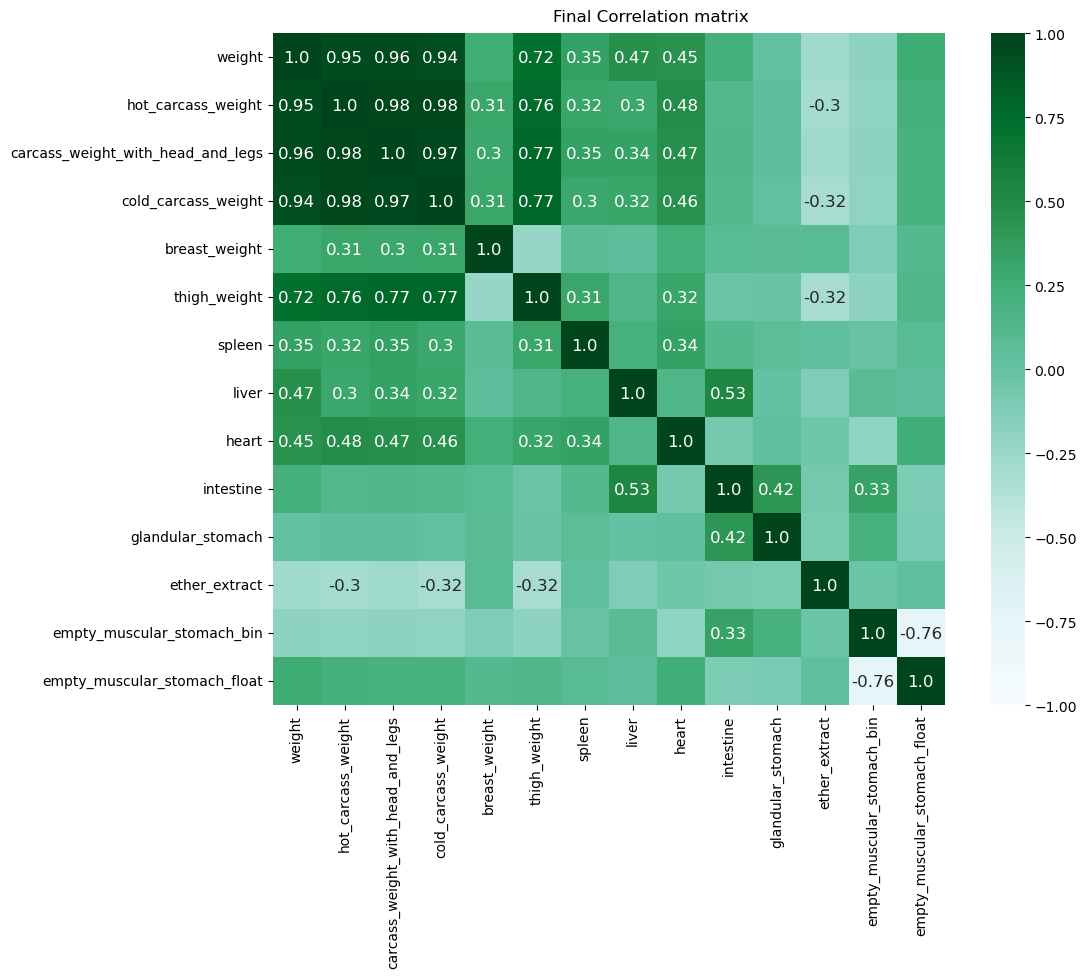

In [141]:
corr = df[features].corr().round(2)
fig = plt.figure(figsize=(12, 8))

# annotation matrix - values above |0.3| will appear in the plot
mask_annot = np.absolute(corr.values) >= 0.3
annot = np.where(mask_annot, corr.values, np.full(corr.shape, ''))
sns.heatmap(data = corr, annot = annot, cmap = 'BuGn', fmt = 's', vmin = -1, vmax = 1, center = 0, square = True, linewidths = 0, annot_kws = {'size': 12})

fig.subplots_adjust(top = 0.95)
fig.suptitle('Final Correlation matrix');

In [142]:
temos muitas corr, é para dar drop ou temos de usar todas 

SyntaxError: invalid syntax (3105232982.py, line 1)

We are going to keep `empty_muscular_stomach_bin` since it has a better correlation witht the target.

In [143]:
df['empty_muscular_stomach'] = df['empty_muscular_stomach_bin'] 

In [145]:
df = df.drop(columns=['empty_muscular_stomach_float', 'empty_muscular_stomach_bin'])

### <a id="method-selection"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: center; margin-top: 20px; margin-bottom: 20px;">
    <h3 style="color: white; margin: 0;">Choosing the method and parameters for each model</h3>
</div>

[Back to Index](#idx)

- [1. Nested cross-validation vs. Monte Carlo cross-validation](#method) 
- [2. Genetic Programming (GP)](#gp) - Delivery 1 (Done)
- [3. Geometric Semantic Geometric Programming (GSGP)](#gsgp) - Delivery 2 (Done)
- [4. Semantic Learning algorithm with Inflate and deflate Mutations (SLIM)](#slim)
- [5. Neural Network (NN)](#nn)
- [6. NeuroEvolution of Augmenting Topologies (NEAT)](#neat)

#### <a id="method"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: left; margin-top: 20px; margin-bottom: 20px;">
    <h4 style="color: white; margin: 0;">1. Nested cross-validation vs. Monte Carlo cross-validatio</h4>
</div>

[Back to Index](#idx)

#### Dataset Partition Strategy Justification

In this project, we opted for **nested cross-validation (nested CV)** as our dataset partitioning strategy for both model selection (hyperparameter tuning) and performance evaluation.

This decision was based on the following considerations:

1. **Final Comparative Evaluation Across Algorithms**  
   At the end of the project, _"the same partitions should be used across all the algorithms to be studied"_, we will compare Genetic Programming (GP) and Geometric Semantic Genetic Programming (GSGP) and other machine learning algorithms.  
   To ensure a **fair and unbiased comparison**, the **same dataset partitions** must be used across all algorithms (are all evaluated under the same conditions basically) - Nested CV provides a systematic and reproducible way to maintain this consistency.

2. **Separation of Concerns: Tuning vs. Evaluation**  
   Nested CV explicitly separates the hyperparameter optimization (inner loop) from the model evaluation (outer loop).  
   This avoids **information leakage** and reduces the risk of **overfitting during model selection**, which is particularly relevant for algorithms like GP that are prone to overfitting and premature convergence.
   "the advantage of doing several iterations in cross-validation is that it allows us to obtain an error estimate that is not dependent on a single data splitting and a particular choice of the training data"_ (Vanneschi & Silva, Sec. 5.3, p.130). Nested CV extends this robustness by adding an inner loop for model selection, which further reduces the risk of biased or optimistic performance estimation.

3. **Avoiding Pitfalls of Monte Carlo CV in This Context**
   Although Monte Carlo cross-validation (or repeated random subsampling) can be viewd as an alternative (Vanneschi & Silva, p.130-131), it comes with a notable limitation: _"some observations may never be selected for the test set, while others will be selected more than once"_. In this project, where a **comparative and reproducible evaluation across multiple algorithms is required**, this irregularity makes Monte Carlo CV less appropriate than nested CV.  Using a **K-Fold outer loop** (e.g., `K=10`) ensures that every instance in the dataset is used for testing exactly once, and for training K-1 times, and combined with an **inner K-Fold** (e.g., `K=5`) for tuning, this strategy enables robust **statistical comparisons** (e.g., Wilcoxon tests, Friedman + Nemenyi post-hoc), which are essential to draw valid conclusions about performance differences between models.

   The  different CV strategies may be appropriate for different phases: _"it may make sense to use 5-fold or 10-fold cross-validation for choosing the method and parameters (...) and then use Monte Carlo (...) for a thorough estimation of the error"_ (p.131).  
   However, since our pipeline includes both tuning and evaluation as part of the **same CV process**, and comparison across methods is the final goal, we apply nested CV consistently for both.

4. Despite the relatively small size of our dataset (96 instances), we argue that nested cross-validation remains a justified choice. As pointed out by Vanneschi & Silva (Section 5.3), the reliability of performance estimation is a crucial concern when data is scarce. Nested CV is particularly effective in avoiding overfitting during hyperparameter tuning, which becomes even more critical under these circumstances.

The training and test sets generated in each fold still preserve enough data to fit and evaluate meaningful models. Moreover, since the dataset is small, the computational overhead introduced by nested CV is negligible.

In summary, while some may consider using Monte Carlo cross-validation to reduce computational cost or avoid small folds, the benefits of using nested cross-validation — particularly in terms of fair model selection and unbiased generalization error estimation — outweigh the drawbacks, especially when working with limited data.


In [72]:
target = 'crude_protein'
X = df.drop(columns=[target])
y = df[target]

In [155]:
def nested_cv_generator(X, y, k_outer=5, k_inner=3, random_state=None, scaler_cls=RobustScaler):
    """
    Gera folds para nested cross-validation com scaling aplicado dentro dos folds (sem leakage).
    Yields: dict com os conjuntos: X_train, X_val, X_test, y_train, y_val, y_test, e os índices usados
    """
    outer_cv = KFold(n_splits=k_outer, shuffle=True, random_state=random_state)

    for outer_train_idx, outer_test_idx in outer_cv.split(X): #does not reuse the outer test set during training or validation
        X_outer_train, X_test = X[outer_train_idx], X[outer_test_idx]
        y_outer_train, y_test = y[outer_train_idx], y[outer_test_idx]

        inner_cv = KFold(n_splits=k_inner, shuffle=True, random_state=random_state)

        for inner_train_idx, inner_val_idx in inner_cv.split(X_outer_train):
            X_train, X_val = X_outer_train[inner_train_idx], X_outer_train[inner_val_idx]
            y_train, y_val = y_outer_train[inner_train_idx], y_outer_train[inner_val_idx]

            # Scaling (fit on train only!)
            scaler = scaler_cls()
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)
            X_test_scaled = scaler.transform(X_test)

            yield {
                'X_train': X_train_scaled,
                'X_val': X_val_scaled,
                'X_test': X_test_scaled,
                'y_train': y_train,
                'y_val': y_val,
                'y_test': y_test,
                'indices': {
                    'outer_train': outer_train_idx,
                    'outer_test': outer_test_idx,
                    'inner_train': inner_train_idx,
                    'inner_val': inner_val_idx,
                }
            }

#### <a id="gp"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: left; margin-top: 20px; margin-bottom: 20px;">
    <h4 style="color: white; margin: 0;">2. Genetic Programming (GP)</h4>
</div>

[Back to Index](#idx)

In [ ]:
import torch
import itertools

In [154]:
#os.makedirs("logs", exist_ok=True)

In [156]:
def cross_val_gp_slim(X, y, cv=10, random_state=42, run_name="default", **gp_config):
    X = X.values
    y = y.values
    scores = []  # Test scores across folds

    log_dir = "./logs"
    os.makedirs(log_dir, exist_ok=True)  # Create log folder if missing

    for fold_idx, fold_data in enumerate(nested_cv_generator(X, y, k_outer=cv, k_inner=3, random_state=random_state)):
        X_train = fold_data['X_train']
        X_val = fold_data['X_val']
        X_test = fold_data['X_test']
        y_train = fold_data['y_train']
        y_val = fold_data['y_val']
        y_test = fold_data['y_test']

        print(f"[Fold {fold_idx+1}] Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

        # Convert to tensors
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

        # Prepare GP instance
        model = gp(
            # --- Problem instance ---
            X_train=X_train_tensor, y_train=y_train_tensor,
            X_test=X_val_tensor, y_test=y_val_tensor,
            fitness_function='rmse',
            minimization=True,

            # --- Search space ---
            initializer=gp_config['initializer'],
            tree_constants=gp_config['sspace']['constant_set'],
            tree_functions=gp_config['sspace']['function_set'],
            prob_const=gp_config['sspace']['p_constants'],
            init_depth=gp_config['sspace']['max_init_depth'],
            max_depth=gp_config['sspace']['max_depth'],

            # --- GP parameters ---
            pop_size=gp_config['pop_size'],
            p_xo=gp_config['xo_prob'],
            elitism=gp_config['has_elitism'],
            n_elites=1,
            tournament_size=int(1 / gp_config['selection_pressure']),

            # --- Solve settings ---
            n_iter=gp_config['generations'],
            test_elite=True,
            log_level=2,
            log_path=f"{log_dir}/gp_{run_name}_fold{fold_idx+1}.csv",
            verbose=1,
            n_jobs=1,
            seed=gp_config['seed']
        )

        # Final model evaluation (on outer test set)
        with torch.no_grad():
            y_pred = model.predict(X_test_tensor)
            test_rmse = torch.sqrt(torch.mean((y_pred - y_test_tensor) ** 2)).item()

        print(f"[Fold {fold_idx+1}] Test RMSE: {test_rmse:.4f}")
        scores.append(test_rmse)

    return np.array(scores)

- Dataset size: 96 samples
- Nested CV: test set = ~19 samples (outer fold), train+val = ~77 samples
- GP can overfit easily on small data if trees get too big or the population too complex

| **Parameter**        | **Test Values**                                | **Why ??**                                                                                             |
| -------------------- | ----------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------- |
| `init_depth`         | `[2, 3]`                                              | Smaller initial trees (shallow depth) reduce the risk of overfitting early on. With 96 entries, you want simplicity and better generalization.  |
| `max_depth`          | `[6, 10]`                                             | Limits the model's complexity. Deep trees overfit easily on small datasets. Capping depth avoids bloated or overly specific programs.           |
| `tree_constants`     | `[random.uniform(-1, 1) for _ in range(9)] + [-1]`    | Constants allow models to fine-tune predictions. Using a limited, balanced range prevents excessive reliance on constants (avoids "bloat").     |
| `p_constants`        | `[0.1, 0.2]`                                          | High constant probability makes the tree more about constants than structure. This is dangerous for small data — prefer 10–20% range.           |
| `tree_functions`     | `['add', 'subtract', 'multiply', 'protected_divide']` | Basic arithmetic gives expressive power. `protected_divide` avoids runtime errors. Don’t add too many functions — it increases search space.    |
| `pop_size`           | `[20, 30, 50]`                                        | Small datasets don’t need huge populations. Lower sizes = faster runs and still enough diversity. 20–50 is a good starting point.               |
| `p_xo`               | `[0.7, 0.9]`                                          | Crossover (recombination) promotes diversity and generalization. On small data, too much crossover (close to 1.0) might disrupt good solutions. |
| `selection_pressure` | `[0.33, 0.5] → tournament_size = 3 or 2`              | Lower pressure encourages exploring a diverse set of solutions. This helps prevent premature convergence — which is a risk with small datasets. |
| `initializer`        | `"grow", "rhh"`                                       | `grow` creates variable-sized trees. `rhh` mixes it with `full`, adding diversity. Avoid `full` alone — it tends to create deep, overfit trees. |
| `elitism`            | `[True]`                                              | Keep the best solution in each generation. With few samples, losing the best-performing individual can seriously hurt performance.              |
| `n_iter`             | `30`                                                  | Reasonable trade-off between computation and convergence. Too many iterations with small data can lead to overfitting.                          |



Running the full CV 3 times with different seeds to mitigate randomness from GP (e.g., in init, selection, mutation), and get statistically more reliable average performance (like doing 30 folds total) -> common trick in evolutionary algorithms due to their stochastic nature.

In [ ]:
# Results collector
results_gp_nested_small = []

# Run 1
run_1 = cross_val_gp_slim(
    X=train,
    y=target,
    cv=10,
    run_name="nested_gp_run1",
    random_state=42,
    **gp_config
)
results_gp_nested_small.append(run_1)
print("Run 1 mean:", np.mean(run_1))
del run_1; gc.collect()

# Run 2
gp_config['seed'] = 25
run_2 = cross_val_gp_slim(
    X=train,
    y=target,
    cv=10,
    run_name="nested_gp_run2",
    random_state=25,
    **gp_config
)
results_gp_nested_small.append(run_2)
print("Run 2 mean:", np.mean(run_2))
del run_2; gc.collect()

# Run 3
gp_config['seed'] = 63
run_3 = cross_val_gp_slim(
    X=train,
    y=target,
    cv=10,
    run_name="nested_gp_run3",
    random_state=63,
    **gp_config
)
results_gp_nested_small.append(run_3)
print("Run 3 mean:", np.mean(run_3))
del run_3; gc.collect()

# Flatten all scores
results_gp_nested_small = list(itertools.chain.from_iterable(results_gp_nested_small))
print("All scores:", results_gp_nested_small)
print("Mean of all:", np.mean(results_gp_nested_small))


#### <a id="gsgp"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: left; margin-top: 20px; margin-bottom: 20px;">
    <h4 style="color: white; margin: 0;">3. Geometric Semantic Geometric Programming (GSGP)</h4>
</div>

[Back to Index](#idx)

We are going to keep `empty_muscular_stomach_bin` since it has a better correlation witht the target.

## <a id="error-estimation"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: center; margin-top: 20px; margin-bottom: 20px;">
    <h3 style="color: white; margin: 0;">Estimating the predictive error</h3>
</div>

[Back to Index](#idx)

usar isto para justificar o uso de rmse:


MAE is not very sensitive to outliers in comparison to MSE since it doesn’t
punish huge errors.


• MSE is more accurate than MAE as it highlights large errors over small ones.

• MSE is differentiable which helps find the minimum and maximum values
using mathematical methods more effectively.
But…

• MSE “squares” all the values, and so errors are extremized (each error point
has a large impact).

When to use MAE:
• when outliers in the data are comparatively
low, as it is not very sensitive to the outlier

It is used when the performance is measured
on continuous variable data as it gives a linear
value, which averages the weighted individual
differences equally.
When to use MSE:
• when the dataset contains outliers, or
unexpected values (too high or too low
values).


When to use RMSE:
• RMSE assigns a higher weight to larger
errors as errors are squared before they are
averaged.
This indicates that RMSE is much more useful
when large errors are present and they
drastically affect the model’s performance.





<a id="final-testing"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: center; margin-top: 20px; margin-bottom: 20px;">
    <h3 style="color: white; margin: 0;">Testing the final model</h3>
</div>

[Back to Index](#idx)